In [1]:
cd ..

/home/tommy/Scrivania/Polimi/Honours Programme/SCFR


In [2]:
from os import listdir
import json
import matplotlib.pyplot as plt

In [3]:
def parameters_to_string(par):
    if(par['game'] == 'kuhn'):
        return 'kuhn_' + str(par['players']) + '_' + str(par['rank'])
    if(par['game'] == 'leduc'):
        return 'leduc_' + str(par['players']) + '_' + str(par['suits']) + '_' + str(par['rank'])
    if(par['game'] == 'goofspiel'):
        return 'goofspiel_' + str(par['players']) + '_' + str(par['rank']) + '_' + str(par['tie_solver'])

In [4]:
# TODO: check it, in particular for bigger versions of goofspiel
# TODO: implement different goofspiel TieSolver

def delta_utility(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn':
        return 2 * players
    if game == 'leduc':
        return players + players * betting_parameters[0] + players * betting_parameters[1]
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))

In [5]:
def max_social_welfare(game, players, rank, betting_parameters = [2, 4]):
    if game == 'kuhn' or game == 'leduc':
        return 0
    if game == 'goofspiel':
        return sum(list(range(1, rank+1)))

In [28]:
target_directory = "results/remote/leduc_20190120/"

In [29]:
file_names = listdir(target_directory)

In [30]:
def analyze(name, target_epsilons, time_to_target_per_instance, iterations_to_target_per_instance):
    file = open(target_directory + name, "r")
    data = json.load(file)
    
    print("File = " + name)
    print("Game = " + parameters_to_string(data['parameters']))
    
    print("Total iterations = " + str(data['parameters']['number_iterations']))
    print("Check every iteration = " + str(data['parameters']['check_every_iteration']))
    
    durations = list(map(lambda el: el['duration'], data['data']))
    
    target_datapoint_amount = int(data['parameters']['number_iterations']) / int(data['parameters']['check_every_iteration'])
    run_time = sum(durations)
    print("Logged " + str(len(data['data'])) + " out of " + str(target_datapoint_amount) + " datapoints in " + \
          str(run_time) + " seconds (aka " + str(run_time/3600) + " hours)")

    if 'total_duration' in data:
        running_time = data['total_duration']
        print("Solved in " + str(running_time) + " seconds")
        print("Solved in " + str(running_time / 60) + " minutes")
        print("Solved in " + str(running_time / 3600) + " hours")
        
    if 'utility' in data:
        u = data['utility']
        sw = sum(u)
        print("Final utility = " + str(u))
        print("Social welfare = " + str(sw))
        max_sw = max_social_welfare(data['parameters']['game'], data['parameters']['players'], 
                                    data['parameters']['rank'], data['parameters']['betting_parameters'])
        if max_social_welfare != 0:
            print("Max social welfare = " + str(max_sw) + " (obtained " + \
                  str(sw / max_sw * 100) + "%)")

    if 'total_duration' in data:
        print("Average iterations per second = " + str(data['average_iterations_per_second']))
    
    du = delta_utility(data['parameters']['game'], data['parameters']['players'], data['parameters']['rank'],
                   data['parameters']['betting_parameters'])

    iteration_counts = list(map(lambda el: el['iteration_number'], data['data']))
    epsilons = list(map(lambda el: max(0, -min(el['epsilon'])), data['data']))
    percent_epsilons = list(map(lambda el: el / du, epsilons))
    absolute_joint_sizes = list(map(lambda el: el['absolute_joint_size'], data['data']))
    relative_joint_sizes = list(map(lambda el: el['relative_joint_size'], data['data']))
    max_plan_frequencies = list(map(lambda el: el['max_plan_frequency'], data['data']))
    joint_support_sizes = list(map(lambda el: el['joint_support_size'], data['data']))
    
    plt.plot(iteration_counts, epsilons)
    plt.show()
    plt.plot(iteration_counts, percent_epsilons)
    plt.show()
    
    time_to_target = []
    iterations_to_target = []
    
    for t in target_epsilons:
        indices_below_t = [i for i in range(len(epsilons)) if percent_epsilons[i] <= t]
        if len(indices_below_t) > 0:
            time_to_t = sum(durations[:indices_below_t[0]+1])
            iterations_to_target.append((indices_below_t[0]+1) * int(data['parameters']['check_every_iteration']))
        else:
            time_to_t = -1
            iterations_to_target.append(-1)
        time_to_target.append(round(time_to_t, 5))
    
    s = parameters_to_string(data['parameters'])
    while s in time_to_target_per_instance:
        s += '_'
    time_to_target_per_instance[s] = time_to_target
    iterations_to_target_per_instance[s] = iterations_to_target   

File = 1547913816_3_3_5
Game = leduc_3_3_5
Total iterations = 1000000
Check every iteration = 1000
Logged 51 out of 1000.0 datapoints in 83110.0770149231 seconds (aka 23.086132504145304 hours)


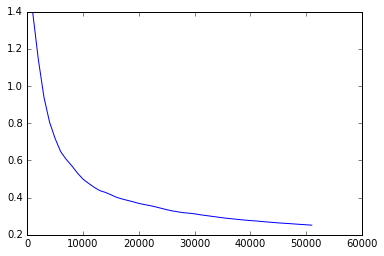

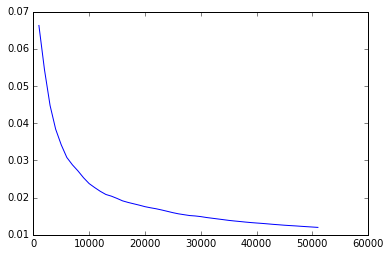

File = 1547913780_3_3_4
Game = leduc_3_3_4
Total iterations = 1000000
Check every iteration = 1000
Logged 85 out of 1000.0 datapoints in 84411.81807374954 seconds (aka 23.447727242708208 hours)


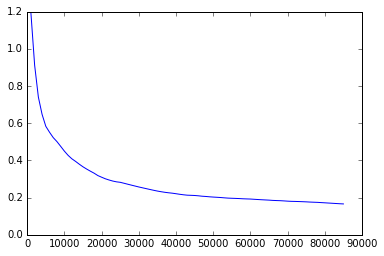

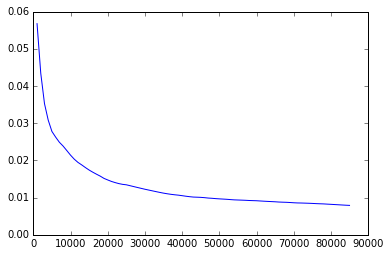

File = 1547830786_3_3_3
Game = leduc_3_3_3
Total iterations = 1000000
Check every iteration = 1000
Logged 239 out of 1000.0 datapoints in 167206.1014199257 seconds (aka 46.44613928331269 hours)


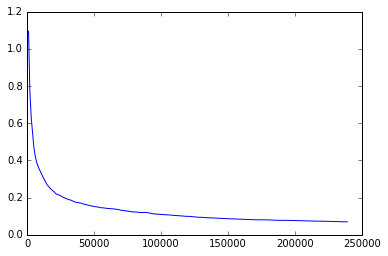

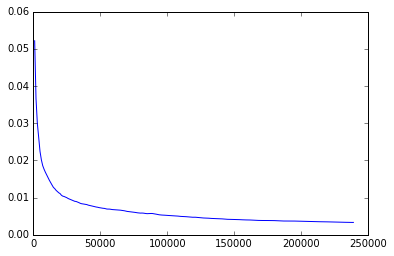

In [31]:
target_epsilons = [10, 5, 2, 1.5, 1, 0.5, 0.2, 0.1, 0.01, 0]
time_to_target_per_instance = {}
iterations_to_target_per_instance = {}

for name in file_names:
    analyze(name, target_epsilons, time_to_target_per_instance, iterations_to_target_per_instance)

In [32]:
from IPython.display import HTML, display
import tabulate

In [33]:
table_text = [['Targets'] + (list(map(str, target_epsilons)))]
for (game, times) in sorted(time_to_target_per_instance.items()):
    line_text = [game] + list(map(lambda t: 'n/a' if t == -1 else str(t), times))
    table_text.append(line_text)

In [34]:
display(HTML(tabulate.tabulate(table_text, tablefmt='html')))

Targets,10,5,2,1.5,1,0.5,0.2,0.1,0.01,0
leduc_3_3_3,49.086,49.086,49.086,49.086,49.086,49.086,49.086,49.086,3325.55586,n/a
leduc_3_3_4,97.6083,97.6083,97.6083,97.6083,97.6083,97.6083,97.6083,97.6083,26434.44727,n/a
leduc_3_3_5,231.998,231.998,231.998,231.998,231.998,231.998,231.998,231.998,n/a,n/a


In [35]:
table_text2 = [['Targets'] + (list(map(str, target_epsilons)))]
for (game, times) in sorted(iterations_to_target_per_instance.items()):
    line_text = [game] + list(map(lambda t: 'n/a' if t == -1 else str(t), times))
    table_text2.append(line_text)

In [36]:
display(HTML(tabulate.tabulate(table_text2, tablefmt='html')))

Targets,10,5,2,1.5,1,0.5,0.2,0.1,0.01,0
leduc_3_3_3,1000,1000,1000,1000,1000,1000,1000,1000,25000,n/a
leduc_3_3_4,1000,1000,1000,1000,1000,1000,1000,1000,46000,n/a
leduc_3_3_5,1000,1000,1000,1000,1000,1000,1000,1000,n/a,n/a
